# Tema 1 Învățare Automată
# Glodea Eusebiu - 342C2
## Setul de date Fruits

*Nota: In documentul de fata a fost implementata tema pentru setul de date fruits. In arhiva temei se va afla si fisierul .ipynb cu implementarea temei pentru setul de date fashion.*

## Pregatirea mediului de lucru

In [1]:
# dureaza ~1 min
from __future__ import annotations
from typing import Optional, Dict, Callable
from pathlib import Path
from copy import deepcopy
from collections import Counter

import pandas as pd
import numpy as np
from graphviz import Digraph, Source
from IPython.display import display as idisplay
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

from scipy.stats import chi2_contingency
from scipy import stats

import urllib.request
import os
import zipfile
import tensorflow as tf

import cv2
import glob
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC


import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)





Path to dataset files: /root/.cache/kagglehub/datasets/moltean/fruits/versions/11


## Pregatirea setului de date Fruits

In [2]:
path2 = "/root/.cache/kagglehub/datasets/moltean/fruits/versions/11" + "/fruits-360_dataset_100x100/fruits-360/"
fruits = os.listdir(path2 + "Training")
dim = 100
def getYourFruits(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = path2 + data_type + "/"
        for i,f in enumerate(fruits):
            p = path + f
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            # if(print_n):
            #     print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = path2 + v + "/"
            for i,f in enumerate(fruits):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels

X_fruits_train, y_fruits_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False)
X_fruits_test, y_fruits_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False)

print("Fruit Training data shape:", X_fruits_train.shape, y_fruits_train.shape)
print("Fruit Test data shape:", X_fruits_test.shape, y_fruits_test.shape)


Fruit Training data shape: (70491, 100, 100, 3) (70491,)
Fruit Test data shape: (23619, 100, 100, 3) (23619,)


# Extragerea de atribute

In [3]:
import cv2
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage.transform import resize
from joblib import Parallel, delayed
from scipy.ndimage import zoom

## Metoda PCA (Principal Component Analysis)

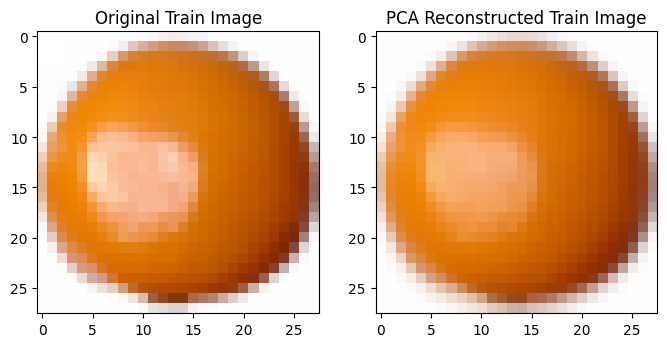

In [ ]:
first_50_images = X_fruits_train[:50]

resized_images = [resize(image, (28, 28), anti_aliasing=True) for image in first_50_images]
flattened_images = np.array([image.reshape(-1) for image in resized_images])

n_components = 50
pca = PCA(n_components=n_components)
images_pca = pca.fit_transform(flattened_images)

def reconstruct_image_tf(image_pca, pca, mean):
    reconstructed_flat = pca.inverse_transform(image_pca)
    reconstructed_flat = reconstructed_flat + mean
    reconstructed_image = reconstructed_flat.reshape(resized_images[0].shape)
    reconstructed_image = (reconstructed_image - reconstructed_image.min()) / (reconstructed_image.max() - reconstructed_image.min())
    return reconstructed_image

components = pca.components_
mean = pca.mean_

reconstructed_image = reconstruct_image_tf(images_pca[0].reshape(1, -1), pca, mean)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(resized_images[0])
axes[0].set_title('Original Train Image')
axes[1].imshow(reconstructed_image)
axes[1].set_title('PCA Reconstructed Train Image')
plt.show()

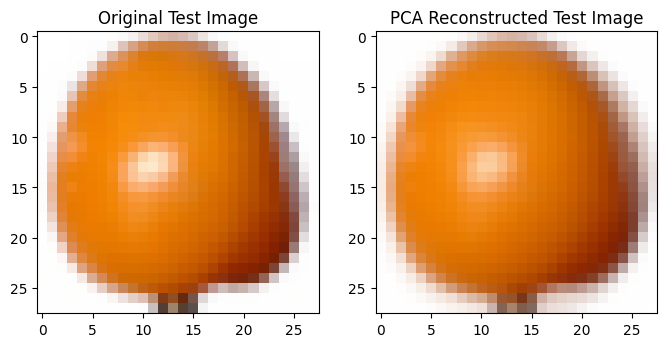

In [ ]:
first_50_images = X_fruits_test[:50]

resized_images = [resize(image, (28, 28), anti_aliasing=True) for image in first_50_images]
flattened_images = np.array([image.reshape(-1) for image in resized_images])

n_components = 50
pca = PCA(n_components=n_components)
images_pca = pca.fit_transform(flattened_images)

def reconstruct_image_tf(image_pca, pca, mean):
    reconstructed_flat = pca.inverse_transform(image_pca)
    reconstructed_flat = reconstructed_flat + mean
    reconstructed_image = reconstructed_flat.reshape(resized_images[0].shape)
    reconstructed_image = (reconstructed_image - reconstructed_image.min()) / (reconstructed_image.max() - reconstructed_image.min())
    return reconstructed_image

components = pca.components_
mean = pca.mean_

reconstructed_image = reconstruct_image_tf(images_pca[0].reshape(1, -1), pca, mean)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(resized_images[0])
axes[0].set_title('Original Test Image')
axes[1].imshow(reconstructed_image)
axes[1].set_title('PCA Reconstructed Test Image')
plt.show()

## Metoda ORB (Oriented FAST and Rotated BRIEF)

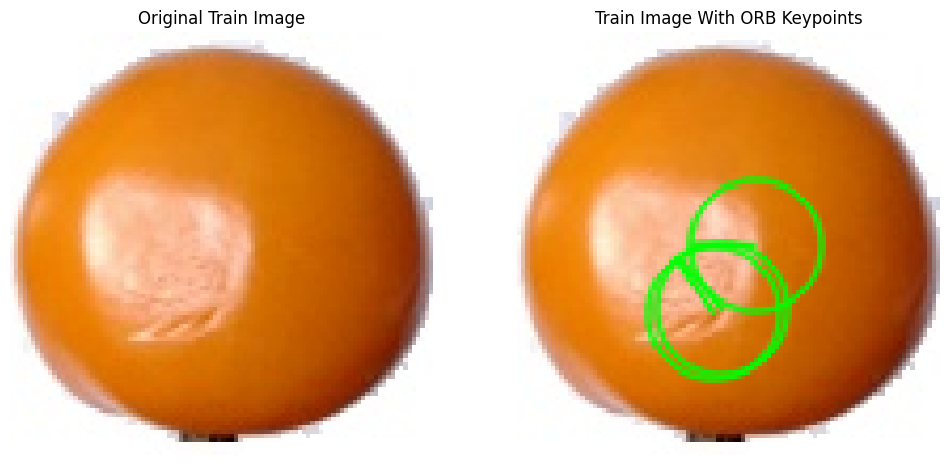

Number of keypoints detected: 3


In [ ]:
first_image = X_fruits_train[0]
gray_image = cv2.cvtColor(first_image, cv2.COLOR_RGB2GRAY)
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(gray_image, None)

image_with_keypoints = cv2.drawKeypoints(
    first_image,
    keypoints,
    None,
    color=(0, 255, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(first_image)
axes[0].set_title('Original Train Image')
axes[0].axis('off')

axes[1].imshow(image_with_keypoints)
axes[1].set_title('Train Image With ORB Keypoints')
axes[1].axis('off')

plt.show()

print(f"Number of keypoints detected: {len(keypoints)}")

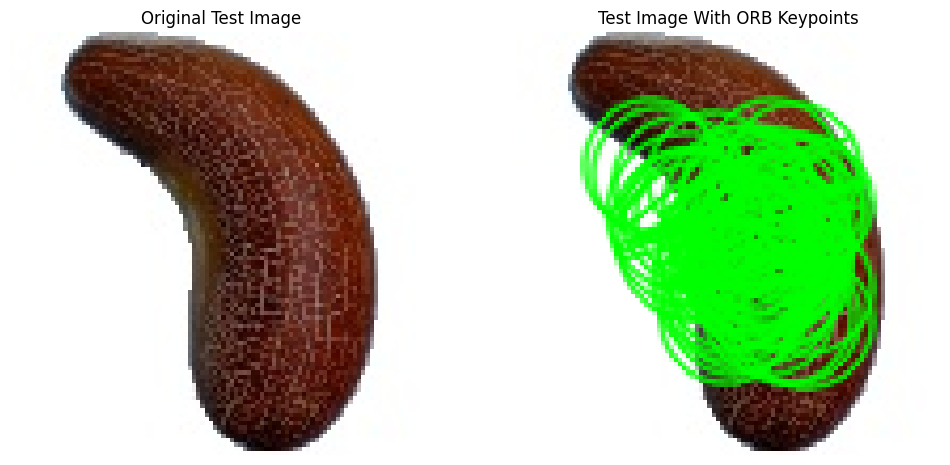

Number of keypoints detected: 52


In [ ]:
first_image = X_fruits_test[4578]
gray_image = cv2.cvtColor(first_image, cv2.COLOR_RGB2GRAY)
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(gray_image, None)

image_with_keypoints = cv2.drawKeypoints(
    first_image,
    keypoints,
    None,
    color=(0, 255, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(first_image)
axes[0].set_title('Original Test Image')
axes[0].axis('off')

axes[1].imshow(image_with_keypoints)
axes[1].set_title('Test Image With ORB Keypoints')
axes[1].axis('off')

plt.show()

print(f"Number of keypoints detected: {len(keypoints)}")

# Vizualizarea Atributelor Extrase

## Analiza echilibrului de clase

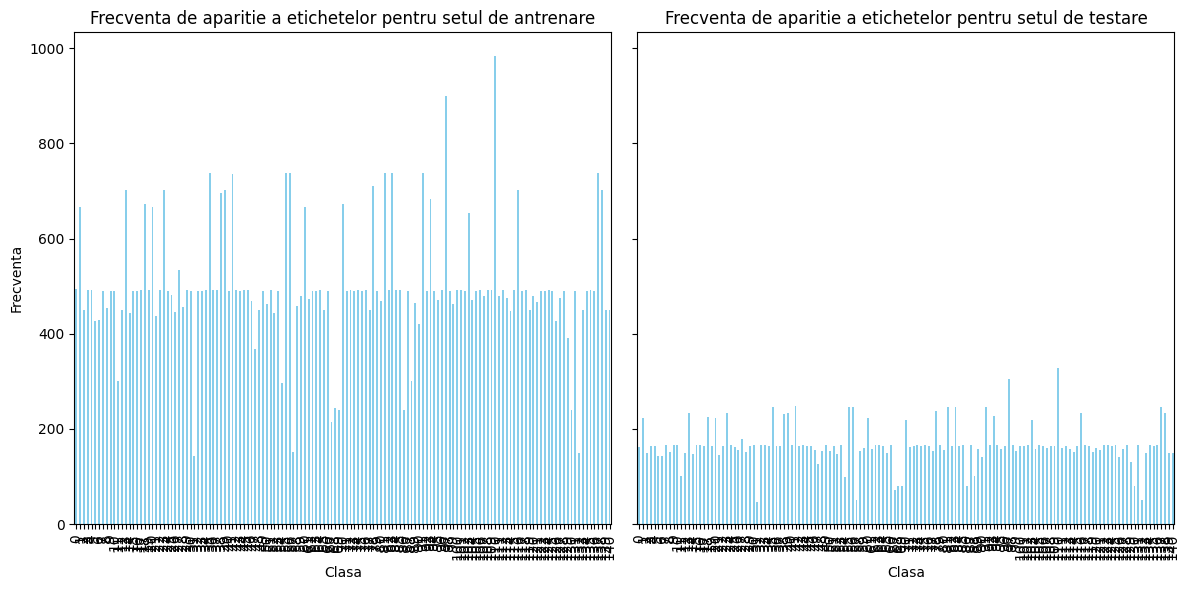

Pentru setul de antrenare, clasa cu cea mai mare frecventa este 110 (cu frecventa de 984), iar clasa cu cea mai mica frecventa este 31 (cu frecventa de 144)
Pentru setul de testare, clasa cu cea mai mare frecventa este 110 (cu frecventa de 328), iar clasa cu cea mai mica frecventa este 31 (cu frecventa de 47)


In [4]:
train_df = pd.DataFrame({'Label': y_fruits_train})
test_df = pd.DataFrame({'Label': y_fruits_test})

train_counts = train_df['Label'].value_counts().sort_index()
test_counts = test_df['Label'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

train_counts.plot.bar(ax=axes[0], color='skyblue')
axes[0].set_title('Frecventa de aparitie a etichetelor pentru setul de antrenare')
axes[0].set_xlabel('Clasa')
axes[0].set_ylabel('Frecventa')

test_counts.plot.bar(ax=axes[1], color='skyblue')
axes[1].set_title('Frecventa de aparitie a etichetelor pentru setul de testare')
axes[1].set_xlabel('Clasa')
axes[1].set_ylabel('Frecventa')

plt.tight_layout()
plt.show()


max_class_train = train_counts.idxmax()
max_freq_train = train_counts.max()

min_class_train = train_counts.idxmin()
min_freq_train = train_counts.min()

max_class_test = test_counts.idxmax()
max_freq_test = test_counts.max()

min_class_test = test_counts.idxmin()
min_freq_test = test_counts.min()


print(f"Pentru setul de antrenare, clasa cu cea mai mare frecventa este {max_class_train} (cu frecventa de {max_freq_train}), iar clasa cu cea mai mica frecventa este {min_class_train} (cu frecventa de {min_freq_train})")
print(f"Pentru setul de testare, clasa cu cea mai mare frecventa este {max_class_test} (cu frecventa de {max_freq_test}), iar clasa cu cea mai mica frecventa este {min_class_test} (cu frecventa de {min_freq_test})")

# print(train_df)
# print(train_counts)

# din 141 de clase


## Vizualizarea cantitativă / calitativă a efectului de extragere a atributelor

In [12]:
# Extragerea celor mai numeroase 10 clase din setul de date Fruits
top_classes_train = train_counts.nlargest(10).index
top_classes_test = test_counts.nlargest(10).index

X_fruits_train_filtered = X_fruits_train[np.isin(y_fruits_train, top_classes_train)]
y_fruits_train_filtered = y_fruits_train[np.isin(y_fruits_train, top_classes_train)]

X_fruits_test_filtered = X_fruits_test[np.isin(y_fruits_test, top_classes_test)]
y_fruits_test_filtered = y_fruits_test[np.isin(y_fruits_test, top_classes_test)]

print("X_fruits_train_filtered:", X_fruits_train_filtered.shape)
print("y_fruits_train_filtered:", y_fruits_train_filtered.shape)

print("X_fruits_test_filtered:", X_fruits_test_filtered.shape)
print("y_fruits_test_filtered:", y_fruits_test_filtered.shape)

X_train, X_test, y_train, y_test = X_fruits_train_filtered, X_fruits_test_filtered, y_fruits_train_filtered, y_fruits_test_filtered

X_fruits_train_filtered: (7785, 100, 100, 3)
y_fruits_train_filtered: (7785,)
X_fruits_test_filtered: (2603, 100, 100, 3)
y_fruits_test_filtered: (2603,)


### Vizualizari cantitative

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from skimage import color
from sklearn.preprocessing import StandardScaler

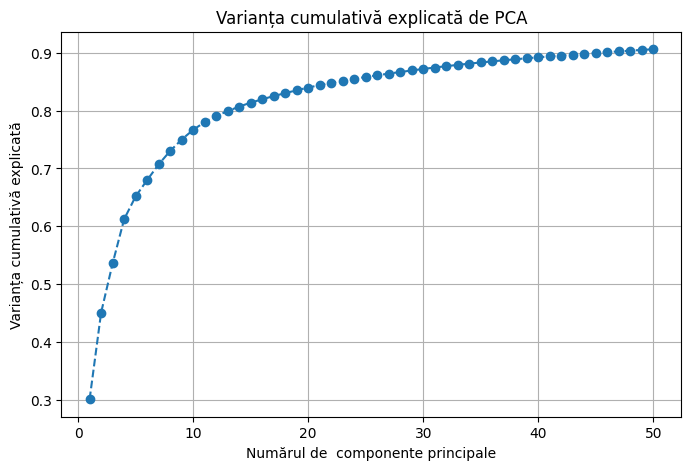

In [ ]:
n_components = 50
n_samples = X_train.shape[0]
X_train_reshaped = X_train.reshape(n_samples, -1)

pca = PCA(n_components=n_components)
pca.fit(X_train_reshaped)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianța cumulativă explicată de PCA')
plt.xlabel('Numărul de  componente principale')
plt.ylabel('Varianța cumulativă explicată')
plt.grid()
plt.show()


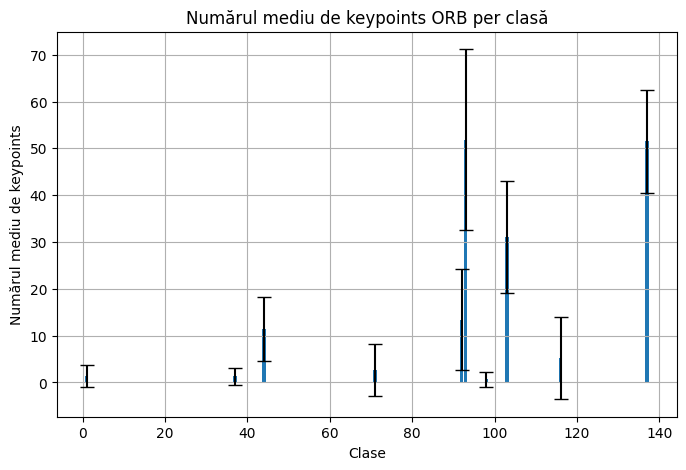

In [ ]:
class_keypoints = {}
orb = cv2.ORB_create()

for image, label in zip(X_train, y_train):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray_image, None)

    if label not in class_keypoints:
        class_keypoints[label] = []
    class_keypoints[label].append(len(keypoints))

class_keypoints_stats = {label: (np.mean(counts), np.std(counts))
                         for label, counts in class_keypoints.items()}

labels = list(class_keypoints_stats.keys())
means = [stats[0] for stats in class_keypoints_stats.values()]
stds = [stats[1] for stats in class_keypoints_stats.values()]


Tabel cu statistici pe clase:
Clasă 1: Media keypoints = 1.37, Deviația standard = 2.39
Clasă 37: Media keypoints = 1.29, Deviația standard = 1.82
Clasă 44: Media keypoints = 11.42, Deviația standard = 6.81
Clasă 71: Media keypoints = 2.70, Deviația standard = 5.61
Clasă 92: Media keypoints = 13.42, Deviația standard = 10.78
Clasă 93: Media keypoints = 51.86, Deviația standard = 19.32
Clasă 98: Media keypoints = 0.62, Deviația standard = 1.66
Clasă 103: Media keypoints = 31.14, Deviația standard = 11.96
Clasă 116: Media keypoints = 5.23, Deviația standard = 8.82
Clasă 137: Media keypoints = 51.51, Deviația standard = 11.01


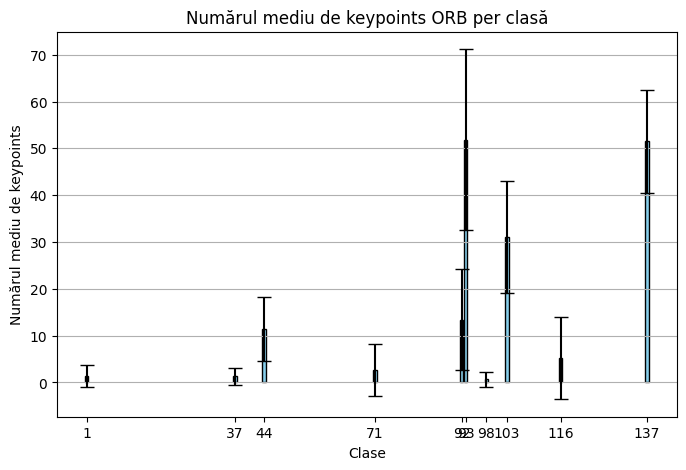

In [ ]:
print("\nTabel cu statistici pe clase:")
for label, stats in class_keypoints_stats.items():
    mean, std = stats
    print(f"Clasă {label}: Media keypoints = {mean:.2f}, Deviația standard = {std:.2f}")

labels = list(class_keypoints_stats.keys())
means = [stats[0] for stats in class_keypoints_stats.values()]
stds = [stats[1] for stats in class_keypoints_stats.values()]

plt.figure(figsize=(8, 5))
plt.bar(labels, means, yerr=stds, capsize=5, color='skyblue', edgecolor='black')
plt.title('Numărul mediu de keypoints ORB per clasă')
plt.xlabel('Clase')
plt.ylabel('Numărul mediu de keypoints')
plt.grid(axis='y')
plt.xticks(labels)
plt.show()



### Vizualizari calitative

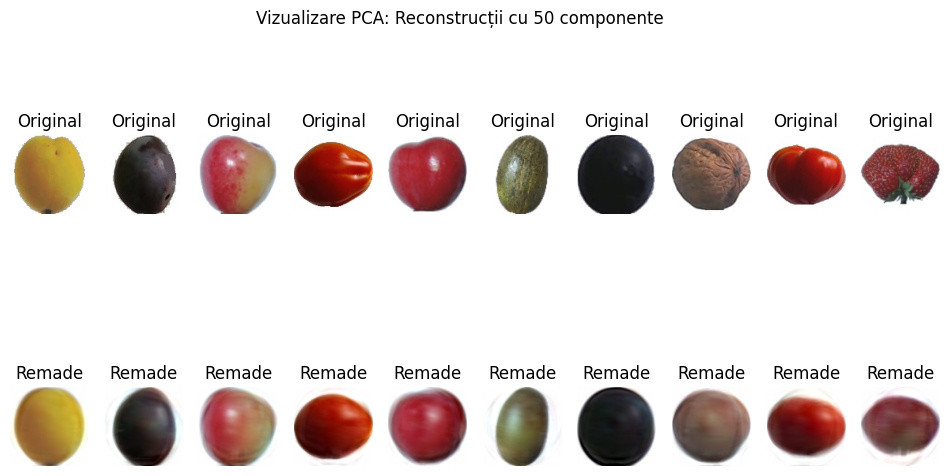

In [ ]:
def visualize_pca_reconstruction(X_images, y_labels, classes, n_components=50):
    fig, axes = plt.subplots(2, len(classes), figsize=(12, 6))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    n_samples = X_images.shape[0]
    X_reshaped = X_images.reshape(n_samples, -1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped)

    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)

    for i, cls in enumerate(classes):
        idx = np.where(y_labels == cls)[0][0]
        original_image = X_images[idx]
        original_image_reshaped = original_image.reshape(1, -1)
        original_image_scaled = scaler.transform(original_image_reshaped)

        reduced = pca.transform(original_image_scaled)
        reconstructed_scaled = pca.inverse_transform(reduced)
        reconstructed = scaler.inverse_transform(reconstructed_scaled)
        reconstructed_image = reconstructed.reshape(original_image.shape)
        reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

        axes[0, i].imshow(original_image)
        axes[0, i].set_title(f'Original')
        axes[0, i].axis('off')

        axes[1, i].imshow(reconstructed_image)
        axes[1, i].set_title(f'Remade')
        axes[1, i].axis('off')

    plt.suptitle(f'Vizualizare PCA: Reconstrucții cu {n_components} componente')
    plt.show()


classes = np.unique(y_train)
visualize_pca_reconstruction(X_train, y_train, classes, n_components=50)



Clasa '1' - Număr de puncte cheie detectate: 0
Clasa '37' - Număr de puncte cheie detectate: 1
Clasa '44' - Număr de puncte cheie detectate: 11
Clasa '71' - Număr de puncte cheie detectate: 1
Clasa '92' - Număr de puncte cheie detectate: 9
Clasa '93' - Număr de puncte cheie detectate: 68
Clasa '98' - Număr de puncte cheie detectate: 3
Clasa '103' - Număr de puncte cheie detectate: 28
Clasa '116' - Număr de puncte cheie detectate: 1
Clasa '137' - Număr de puncte cheie detectate: 43


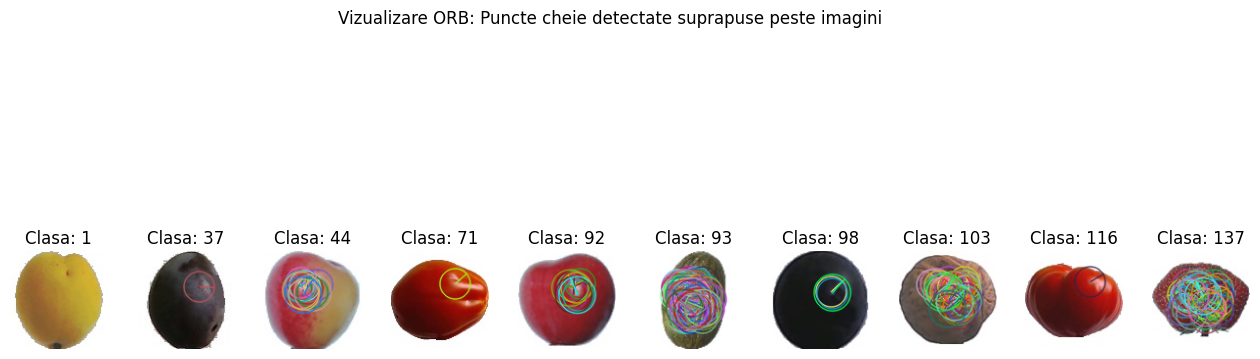

In [ ]:
def visualize_orb_keypoints(X_images, y_labels, classes, n_features=500):
    orb = cv2.ORB_create(nfeatures=n_features)

    fig, axes = plt.subplots(1, len(classes), figsize=(16, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, cls in enumerate(classes):
        idx = np.where(y_labels == cls)[0][0]
        image = X_images[idx]

        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        keypoints, _ = orb.detectAndCompute(gray_image, None)

        output_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

        axes[i].imshow(output_image)
        axes[i].set_title(f'Clasa: {cls}')
        axes[i].axis('off')

        print(f"Clasa '{cls}' - Număr de puncte cheie detectate: {len(keypoints)}")

    plt.suptitle("Vizualizare ORB: Puncte cheie detectate suprapuse peste imagini")
    plt.show()

classes = np.unique(y_train)
visualize_orb_keypoints(X_train, y_train, classes, n_features=500)

# Standardizarea și selecția atributelor

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [7]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test.reshape(X_test.shape[0], -1))
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))

# Il aplic ca sa scot feature urile constante (cu varianta 0)
selector = VarianceThreshold()
X_train_scaled = selector.fit_transform(X_train_scaled)
X_test_scaled = selector.transform(X_test_scaled)

select_percentile = SelectPercentile(score_func=f_classif, percentile=5)
X_test_selected = select_percentile.fit_transform(X_test_scaled, y_test)
X_train_selected = select_percentile.fit_transform(X_train_scaled, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 2619  2620  2621  2622  2623  2624  2625  2626  2627  3210  3211  3212
  3213  3214  3215  3798  3799  3800  4092  4093  4094  4095  4096  4097
  4389  4390  4391 28881 28882 28883 28884 28885 28886 28887 28888 28889
 28890 28891 28892 28893 29113 29115 29117 29118 29120 29121 29123 29124
 29125 29126 29127 29128 29129 29130 29131 29132 29133 29135 29354 29356
 29357 29359 29361 29362 29363 29364 29365 29366 29367 29588 29590 29591
 29593 29595 29596 29597 29598] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
print(X_train.shape)
print(X_train_scaled.shape)
print(X_train_selected.shape)
# (7785, 100, 100, 3)
# (7785, 29599)
# (7785, 5920)

(7785, 100, 100, 3)
(7785, 29599)
(7785, 1480)


# Utilizarea algoritmilor de Învățare Automată

In [9]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import pickle

X_train, X_test, y_train, y_test = X_train_selected, X_test_selected, y_train, y_test

In [ ]:
def run_model(model, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='viridis')
    plt.title(f'Confusion Matrix ({model.__class__.__name__})')
    plt.show()

    return best_model, report, accuracy

## Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 10, 'multi_class': 'multinomial'}


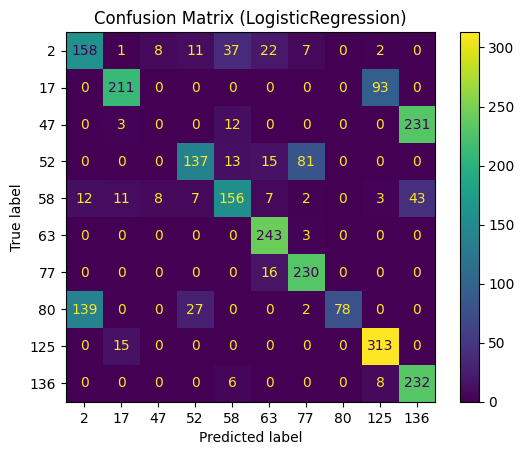

              precision    recall  f1-score   support

           2       0.51      0.64      0.57       246
          17       0.88      0.69      0.77       304
          47       0.00      0.00      0.00       246
          52       0.75      0.56      0.64       246
          58       0.70      0.63      0.66       249
          63       0.80      0.99      0.89       246
          77       0.71      0.93      0.81       246
          80       1.00      0.32      0.48       246
         125       0.75      0.95      0.84       328
         136       0.46      0.94      0.62       246

    accuracy                           0.68      2603
   macro avg       0.66      0.67      0.63      2603
weighted avg       0.66      0.68      0.64      2603



In [ ]:
# dureaza ~1min30sec
lr_model = LogisticRegression(max_iter=5000)
lr_param_grid = {
    'C': [10],
    'multi_class': ['multinomial']
}
lr_params, lr_metrics, lr_accuracy = run_model(lr_model, lr_param_grid, X_train, y_train, X_test, y_test)
print(lr_metrics)


## SVM

Best parameters: {'C': 1, 'kernel': 'linear'}


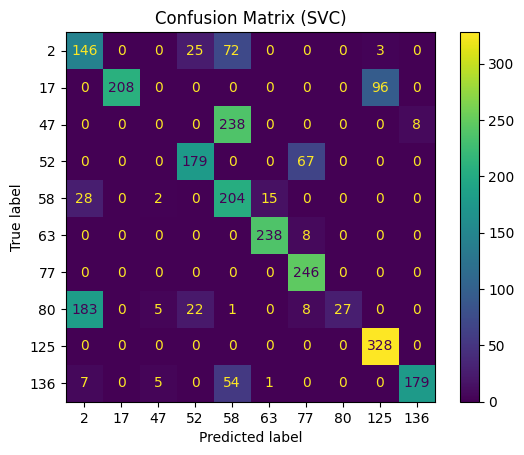

              precision    recall  f1-score   support

           2       0.40      0.59      0.48       246
          17       1.00      0.68      0.81       304
          47       0.00      0.00      0.00       246
          52       0.79      0.73      0.76       246
          58       0.36      0.82      0.50       249
          63       0.94      0.97      0.95       246
          77       0.75      1.00      0.86       246
          80       1.00      0.11      0.20       246
         125       0.77      1.00      0.87       328
         136       0.96      0.73      0.83       246

    accuracy                           0.67      2603
   macro avg       0.70      0.66      0.62      2603
weighted avg       0.70      0.67      0.64      2603



In [ ]:
# dureaza ~
svm_model = SVC()
svm_param_grid = {
    'C': [1],
    'kernel': ['linear']
}
svm_params, svm_metrics, svm_accuracy = run_model(svm_model, svm_param_grid, X_train, y_train, X_test, y_test)
print(svm_metrics)

## Random Forest

Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}


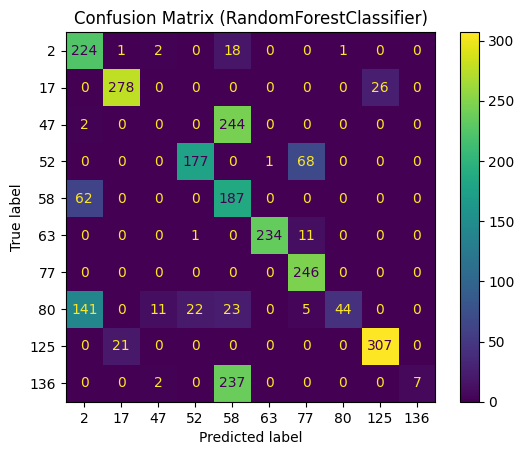

              precision    recall  f1-score   support

           2       0.52      0.91      0.66       246
          17       0.93      0.91      0.92       304
          47       0.00      0.00      0.00       246
          52       0.89      0.72      0.79       246
          58       0.26      0.75      0.39       249
          63       1.00      0.95      0.97       246
          77       0.75      1.00      0.85       246
          80       0.98      0.18      0.30       246
         125       0.92      0.94      0.93       328
         136       1.00      0.03      0.06       246

    accuracy                           0.65      2603
   macro avg       0.72      0.64      0.59      2603
weighted avg       0.73      0.65      0.61      2603



In [ ]:
# dureaza ~
rf_model = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [15],
    'max_features': ['sqrt']
}
rf_params, rf_metrics, rf_accuracy = run_model(rf_model, rf_param_grid, X_train, y_train, X_test, y_test)
print(rf_metrics)

## Gradient Boosted Trees

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 150}


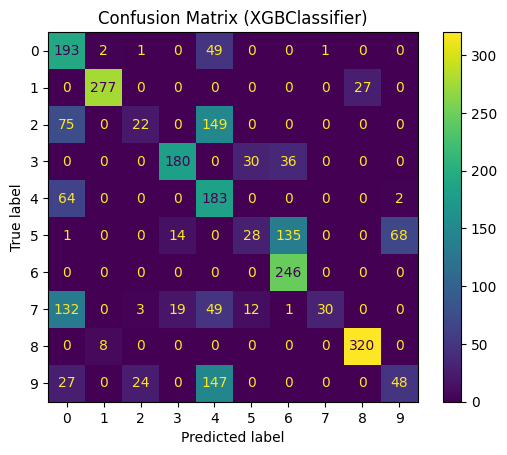

In [ ]:
# dureaza ~17min30sec
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [150],
    'max_depth': [15],
    'learning_rate': [0.1]
}
xgb_params, xgb_metrics, xgb_accuracy = run_model(xgb_model, xgb_param_grid, X_train, y_train_encoded, X_test, y_test_encoded)

In [ ]:
print(xgb_metrics)

              precision    recall  f1-score   support

           0       0.39      0.78      0.52       246
           1       0.97      0.91      0.94       304
           2       0.44      0.09      0.15       246
           3       0.85      0.73      0.78       246
           4       0.32      0.73      0.44       249
           5       0.40      0.11      0.18       246
           6       0.59      1.00      0.74       246
           7       0.97      0.12      0.22       246
           8       0.92      0.98      0.95       328
           9       0.41      0.20      0.26       246

    accuracy                           0.59      2603
   macro avg       0.62      0.57      0.52      2603
weighted avg       0.64      0.59      0.54      2603

